In [75]:
import numpy as np
from sklearn.datasets import fetch_kddcup99
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.sparse import random as sparse_random

In [65]:
warnings.filterwarnings("ignore")

In [3]:
data = fetch_kddcup99()

In [19]:
n, d = data.data.shape
print(f"Number of samples: {n}")
print(f"Number of features: {d}")

Number of samples: 494021
Number of features: 41


In [52]:
categorical_columns = [i for i in range(data.data.shape[1]) if isinstance(data.data[0, i], bytes)]
categorical_columns

[1, 2, 3]

In [ ]:
label_encoders = {}
for col in categorical_columns:
    data.data[:, col] = [x.decode('utf-8') for x in data.data[:, col]]
    le = LabelEncoder()
    data.data[:, col] = le.fit_transform(data.data[:, col])
    label_encoders[col] = le

In [54]:
D = data.data.astype(float)

In [56]:
print("Shape of the numeric dataset:", D.shape)

Shape of the numeric dataset: (494021, 41)


##### a. Define a family of JL matrices of size \(d \times 20\). Let matrix \(M \in \mathbb{R}^{d \times 20}\) be a uniformly random sample from the family. Notice that \(M\) is a linear transformation that maps a vector from \(\mathbb{R}^d\) to \(\mathbb{R}^{20}\). Compute a mapping of every point in \(D\) as \(E = DM\) and compute k-means clustering, using \(k = 15\). Let \(A\) be the centroids of \(DM\) and \(B\) be the centroids of \(D\). Compute the loss of the k-means clustering on \(D\) using \(A\) and \(B\) respectively. Repeat this experiment 5 times for each random matrix \(M\). Present your result in a table or bar graph.

In [66]:
losses_A = []
losses_B = []

In [61]:
def generate_JL_matrix():
    return np.random.normal(loc = 0, scale = 1/np.sqrt(20), size = (d, 20))

In [62]:
def kmeans_loss(X, k):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    A = kmeans.cluster_centers_
    C = kmeans.labels_
    loss = np.sum(np.linalg.norm(X - A[C], axis=1)**2)
    return loss

In [67]:
for _ in range(5):
    JL = generate_JL_matrix()
    X = D @ JL
    loss_A = kmeans_loss(X, 15)
    loss_B = kmeans_loss(D, 15)
    losses_A.append(loss_A)
    losses_B.append(loss_B)

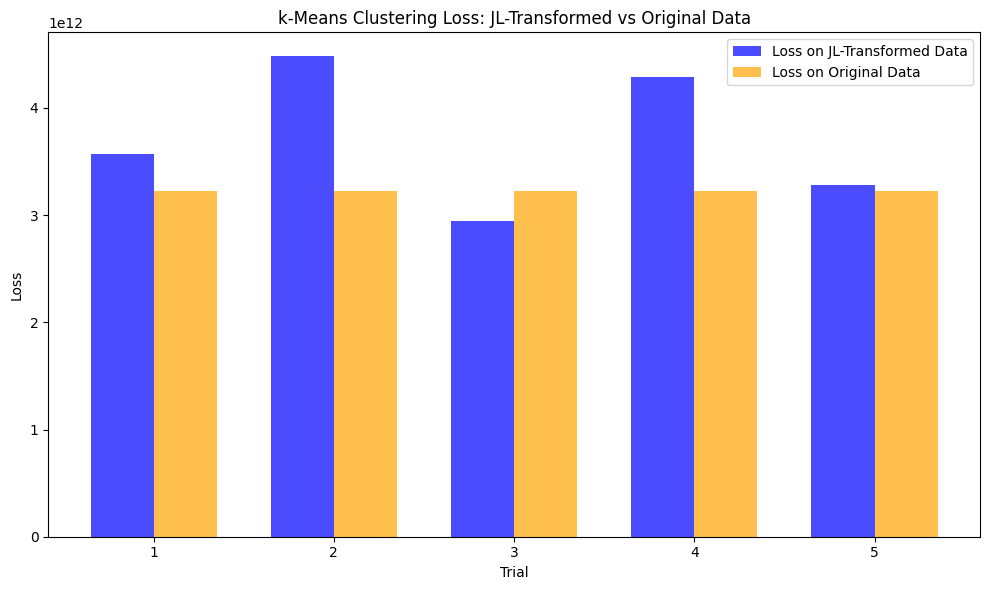

In [74]:
bar_width = 0.35
index = np.array([1, 2, 3, 4, 5])

plt.figure(figsize=(10, 6))
plt.bar(index, losses_A, bar_width, label='Loss on JL-Transformed Data', alpha=0.7, color='blue')
plt.bar(index + bar_width, losses_B, bar_width, label='Loss on Original Data', alpha=0.7, color='orange')

plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('k-Means Clustering Loss: JL-Transformed vs Original Data')
plt.xticks(index + bar_width / 2, [1, 2, 3, 4, 5])
plt.legend()

plt.tight_layout()
plt.show()

##### b. We will run a linear regression on the dataset. Consider the label feature as the target/response as y. It has 23 classes. Define a family of JL matrices of size 10 × n. Notice that the matrix-matrix between a sample from the JL family and D could be very expensive. So, you may use a sparse JL matrix as shown in the class. Let matrix M ∈ R10d×n be a uniformly random sample from the sparse JL family. Compute E = MD and z = My and solve linear regression on (E, z). Also, solve the linear regression on (D,y). Let a be the solution of (E, z) and b be the solution of (D,y). Compute the loss of the linear regression on (D,y) using a and b, respectively. Repeat this experiment 5 times for each random matrix M. Present your result in a table or bar graph.

In [76]:
def generate_sparse_jl_matrix(rows, cols, sparsity=0.1):
    S = sparse_random(rows, cols, density=sparsity, format="csr", random_state=42)
    S.data = np.random.choice([-1, 1], size=S.nnz) * np.sqrt(1 / sparsity)
    return S

In [83]:
losses_A = []
losses_B = []

In [82]:
le = LabelEncoder()
y = le.fit_transform(list(data.target))

In [84]:
for _ in range(5):
    M = generate_sparse_jl_matrix(10 * d, n).toarray()
    E = M @ D
    z = M @ y
    reg_E = LinearRegression().fit(E, z)
    a = reg_E.coef_

    reg_D = LinearRegression().fit(D, y)
    b = reg_D.coef_

    loss_a = np.mean((y - D @ a) ** 2)
    loss_b = np.mean((y - D @ b) ** 2) 

    losses_A.append(loss_a)
    losses_B.append(loss_b)

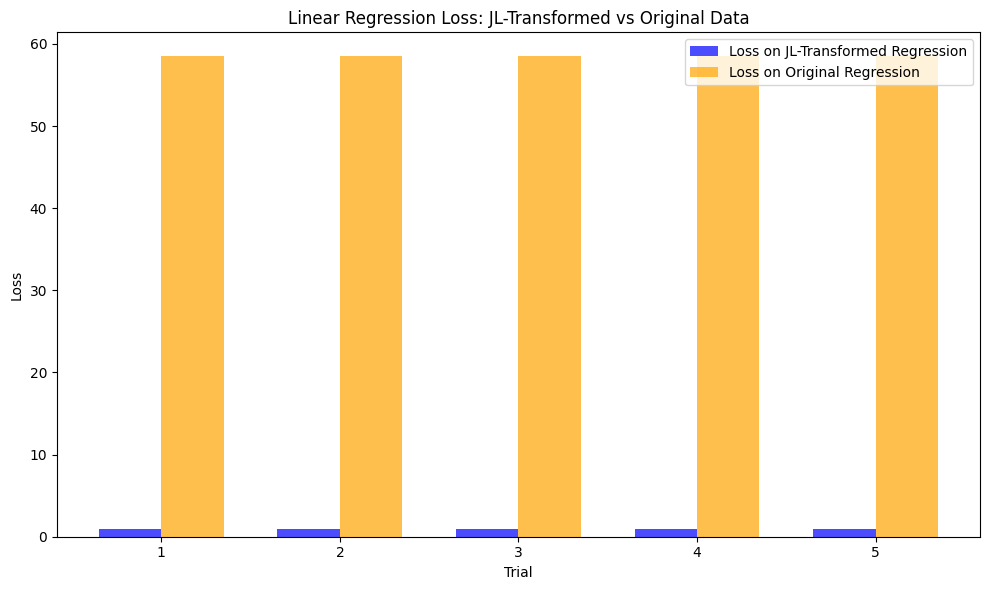

In [85]:
bar_width = 0.35
index = np.array([1, 2, 3, 4, 5])

plt.figure(figsize=(10, 6))
plt.bar(index, losses_A, bar_width, label='Loss on JL-Transformed Regression', alpha=0.7, color='blue')
plt.bar(index + bar_width, losses_B, bar_width, label='Loss on Original Regression', alpha=0.7, color='orange')

plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Linear Regression Loss: JL-Transformed vs Original Data')
plt.xticks(index + bar_width / 2, [1, 2, 3, 4, 5])
plt.legend()

plt.tight_layout()
plt.show()